# Calculate the Oceanic Niño Index (ONI) from NOAA OISST satellite data

## Nino 3.4 and the ONI Index

El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

Source: https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/

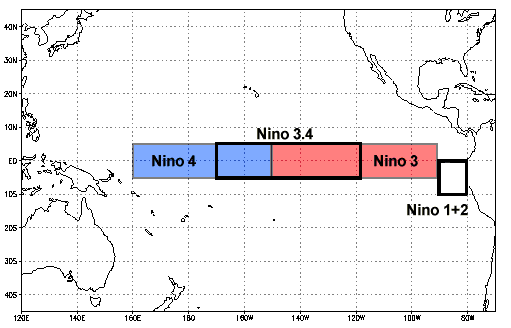

_Niño regions of the equatorial Pacific Ocean. The Niño 3.4 region is used when calculating the Oceanic Niño Index.  Image Credit: NOAA._

### In this notebook, we:


- Load NOAA OISST SST anomaly satellite data from 1982 to 2019


- Average the SST anomalies over the Nino 3.4 region: 5°S-5°N and 190°E to 240°E (Note 240°E = 120°W) and save this to a netcdf file called 'noaa_oisst_v2_sst_anom_nino34.nc'


- Saves the SST anomaly averaged over the Nino 3.4 region to a netcdf file called 'noaa_oisst_v2_sst_anom_nino34.nc'


- Calculate the ONI index, i.e., the 3-month running mean of the Nino 3.4 SST anomalies


- Apply the above definition of El Niño (La Niña) to determine, for each day, the ENSO phase (i.e. El Nino, La Nina or neutral)


- Save the ONI index and event timeseries to a netcdf file called 'noaa_oisst_v2_nino34_index.nc'

In [1]:
# Load required modules.
import numpy as np
import xarray as xr

We're going to open NOAA OISST daily anomaly data from the NOAA website. 

Since we run into problems opening a lot of files all at once, we will seperate and load half of the data into two xarray datasets, take the average over the Nino 3.4 region and then merge (concat) the split timeseries together.

If you get an "NetCDF: I/O failure:" error, these files might have been opened before without shutting them. Try saving your notebook, then going to File> Close and Halt and then try again.

In [2]:
# URL of NOAA OISST daily anomaly data (SST minus climatology). 
# Note that we're not loading the mean daily SST like the first notebook demo.
url_anom = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom'

In [3]:
# Create the first list of NOAA URLs in the year range (split because can't load all files at once).
files_anom_1 = ['{}.{}.v2.nc'.format(url_anom, year) for year in range(1982, 2019 + 1)]

# Open files as an xarray dataset.
ds1 = xr.open_mfdataset(files_anom_1, combine='by_coords')


OSError: [Errno -37] NetCDF: Write to read only: b'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom.2008.v2.nc'

In [ ]:
# Create the second list of NOAA URLs in the year range (split because can't load all files at once).
files_anom_2 = [f'{url_anom}.{year}.v2.nc' for year in range(1999, 2019 + 1)]

# Open files as an xarray dataset.
ds2 = xr.open_mfdataset(files_anom_2, combine='by_coords')
sst_anom_nino34_2 = ds2.anom.sel(lat=slice(-5, 5), lon=slice(190, 240))

In [ ]:
# Merge the split Nino 3.4 arrays.
sst_anom_nino34 = xr.concat([ds1, ds2], dim='time')
sst_anom_nino34

In [ ]:

# Average the SST anomalies over the Nino 3.4 region (5°S-5°N and 190°E-120°W).
# Note that the longitudes go from 0-360°E, so to convert °W to °E you minus the western lat from 360 (i.e. 240°E=360-120°W).
sst_anom_nino34_1 = ds1.anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lon', 'lat'])
ds1.close()

In [ ]:
# Average the SST anomalies over the Nino 3.4 region (5°S-5°N and 190°E-120°W). 
sst_anom_nino34_2 = ds2.anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lon', 'lat'])

Merge the two arrays of SST anomalies together.

In [ ]:
sst_anom_nino34[0]

Create a dataset for Nino 3.4 SST anomalies and copying attributes from the original data files.

In [ ]:
ds = xr.Dataset() # Creates an empty xarray dataset.
ds['nino34'] = sst_anom_nino34 # Add data array called nino34 (this will also add the time coordinate)
ds.attrs = ds2.attrs
ds.nino34.attrs = ds2.anom.attrs

# It's always good to add some metadata so that you know what the file contains when you open it!
ds.nino34.attrs['long_name'] = 'Daily SST anomalies averaged over the Nino 3.4 region'

# Preview what the file will look like.
print(ds.nino34)


In [ ]:
# Saving to a netcdf file (will take quite a while to calculate and save).
ds.to_netcdf('noaa_oisst_sst_anom_nino34.nc') 

# Close the files.
ds.close()
ds2.close()

In [ ]:
ds = xr.open_dataset('noaa_oisst_sst_anom_nino34.nc') 
import matplotlib.pyplot as plt
plt.plot(ds.nino34.time, ds.nino34)
print(ds1.anom.sel(lat=0, lon=190, method='nearest').isel(time=0))


## Now we are going to


 - Calculate the three month running mean of the Nino 3.4 SST anomalies (it smooths out the data), and 
 
 
 - Create an array that tells us which days are considered El Nino, La Nina or Neutral.

In [ ]:
# First open the Nino 3.4 SST anomaly data that we just created.
sst_anom_nino34 = xr.open_dataset('noaa_oisst_sst_anom_nino34.nc')
sst_anom_nino34.nino34

Calculate the 5-month running mean (this is our Nino 3.4 Index)

In [ ]:
oni = sst_anom_nino34.nino34.resample(time='M').mean()
oni
import matplotlib.pyplot as plt
plt.plot(sst_anom_nino34.nino34.time, sst_anom_nino34.nino34)

In [ ]:
13829/30

In [ ]:
oni = sst_anom_nino34.nino34.rolling(time=3).mean()
print(oni)

In [ ]:
print(sst_anom_nino34.nino34)

### Now we start defining ENSO events based on the Nino 3.4 Index

El Nino events are typically defined when the SST anomaly over the central Pacific (our Nino 3.4 area) is greater than 0.5°C and less than 0.5°C for La Nina events. We'll call all other days 'none'.

In [ ]:
nino_thresh = 0.5 # The SST [°C] threshold for definiting events.
nino = xr.full_like(oni, 'none', dtype='U4')
nino[oni >= nino_thresh] = 'nino' # If the SST anomaly is greater than or equal to 0.5°C: label it 'nino'.
nino[oni <= -nino_thresh] = 'nina' # If the SST anomaly is less than or equal to -0.5°C: label it 'nina'.
print(nino) # This is just a time series of days labeled either 'none', 'nino' or 'nina'.

# Printing the sum of El Nino and La Nina days.
print('Number of El Nino days: {} and La Nina days: {}'.format((nino == 'nino').sum().item(), (nino == 'nina').sum().item()))

### To be considered a El Nino or La Nina event, the SST anomaly must be above the threshold for at least 3 months.

Here is my overly complicated way of renaming dates 'none' if there aren't five lots of 3 consecutive months labeled 'nina' or 'nino'. The next cell may take some time to run.

In [ ]:
days = 5*92 # (5 * 3 months)
i = 0 # Counter.
while i < len(nino):
    # Check if day 'i' is tagged as 'nino' or 'nina', otherwise just skip to the next day (i + 1).
    if nino[i] != 'none':
        # Find the next day index that is tagged as 'none'. 
        # Note that nino[i:] is the nino array neglecting all the days before 'i' and np.argwhere will tell us 
        # where all the indexes of 'none' are, but we are only interested in the very next 'none' (i.e. [0][0]).
        end = np.argwhere([n != nino[i] for n in nino[i:]])[0][0]
        
        # So, 'end' number of days after day 'i' is when the next non-event occurs (i.e. the end of the nina or nino event).
        # This means 'end' is the duration of the event. 
        # If the event duration is shorter than the days threshold, rename all these labels as 'none'.
        if end < days:
            nino[i:i + end] = ['none']*(end) 
            
        # Jump up the counter by all the days we just went through.
        i += end + 1
    else:
        i += 1

# Printing the sum of El Nino and La Nina days now (it's probably less than before).
print('Number of El Nino days: {} and La Nina days: {}'.format((nino == 'nino').sum().item(), (nino == 'nina').sum().item()))

Create a dataset (similar to before) for the Nino 3.4 Index (with the rolling mean) and the list of days labeled as either El Nino (nino), La Nina (nina) or neutral (none).

In [ ]:
# Creating a dataset for the Nino 3.4 index and copying attributes from the original files.
ds = xr.Dataset()
ds['oni'] = oni
ds['events'] = nino
ds.attrs = sst_anom_nino34.attrs
ds.oni.attrs = sst_anom_nino34.nino34.attrs
ds.oni.attrs['long_name'] = 'Daily Oceanic Nino Index'
ds.events.attrs['long_name'] = 'ENSO Event'
# Saving to a netcdf file.
ds.to_netcdf('noaa_oisst_v2_oni_index.nc') 
ds.close()